
# XGBoost

dataset: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset?resource=download

Reference used to read dataset:
* https://www.kaggle.com/code/ozguraslank/reading-brain-stroke-ct-dataset



In [ ]:
#Data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

#Modelling
from sklearn.ensemble import RandomForestClassifier #Random Forest Clasification
from sklearn.svm import SVC #C-support vector Clasification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
import xgboost as xgb
import os



## Data processing 

In [2]:
path = 'Brain_Stroke_CT_Dataset/'

#Path de las imágenes
normal_path = path + "Normal" + "/" + "PNG" #Debe ser así pa q funcione tipo expresion regular
ischemia_path = path + "Ischemia" + "/" + "PNG"
bleeding_path = path + "Bleeding" + "/" + "PNG"

#Path de las máscaras
ischemia_mask_path = path + "Ischemia" + "/" + "OVERLAY"
bleeding_mask_path = path + "Bleeding" + "/" + "OVERLAY"

#Obtenemos todas las imágenes
normal_folder = os.listdir(normal_path)
ischemia_folder = os.listdir(ischemia_path)
bleeding_folder = os.listdir(bleeding_path)

#Mostramos cantidad de datos por clase para ver desbalance
size_normal = len(normal_folder)
size_ischemia = len(ischemia_folder)
size_bleeding = len(bleeding_folder)
print("Normal:", size_normal)
print("Ischemia:", size_ischemia)
print("Bleeding:", size_bleeding)


Normal: 4427
Ischemia: 1130
Bleeding: 1093


In [3]:
def process_image(file_path, dim, scale):
    img = Image.open(file_path)
    img = img.convert(scale) #Escala de grises o RGB
    img = img.resize(dim) #Reescalamos
    img = np.array(img)
    return img #.flatten()

In [4]:
#Almacenamos todas las imágenes
data = []
dim = (256, 256) #resize

folders = [normal_folder, ischemia_folder, bleeding_folder]
paths = [normal_path, ischemia_path, bleeding_path]

for i in range(len(folders)):

    #Recorremos todos los archivos de la carpeta y path i 
    for file_name in folders[i]:
        img = process_image(paths[i] + "/" + file_name, dim, 'L') #L = escala de grises
        data.append(img)


In [5]:
#Verificamos dimensión de los datos
data = np.array(data)
data.shape

(6650, 256, 256)

In [6]:
#Creamos el vector de labels
y = np.zeros(6650)
y[:size_normal] = 0 #Normal label [0:4427]
y[size_normal:size_normal+size_ischemia] = 1 #Ishcemia label [4427: 5557]
y[size_normal+size_ischemia:] = 2   #bleeding label [5557:]
y.shape


(6650,)

### Image examples

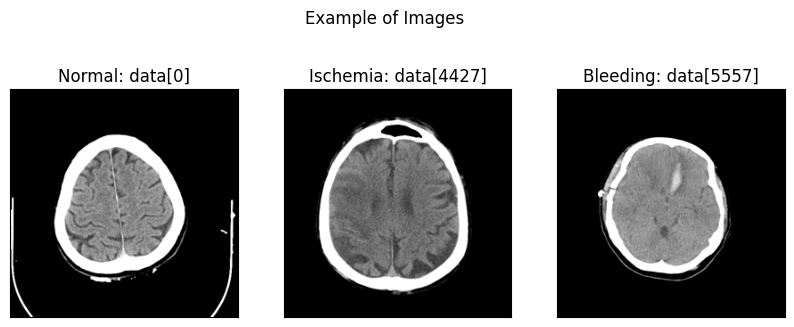

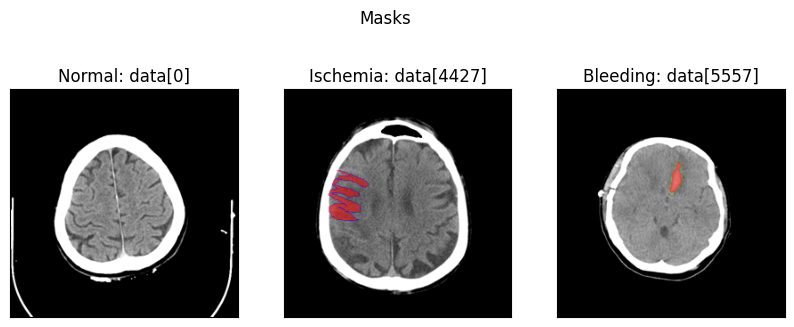

In [7]:
#Mostrmoas una imágen de ejemplo (para ver si el vector y está bien)
f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Example of Images")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(data[0].reshape(dim), cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(data[4427].reshape(dim), cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(data[5557].reshape(dim), cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


#We will also show the masks of the above pictures (manual)
data0_path =    normal_path    + "/10000.png"
data4427_path = ischemia_mask_path  + "/10003.png"
data5557_path = bleeding_mask_path  + "/10002.png"

mask_data0 = process_image(data0_path, dim, "RGB")
mask_data4427 = process_image(data4427_path, dim, "RGB")
mask_data5557 = process_image(data5557_path, dim, "RGB")

f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Masks")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(mask_data0.reshape((dim[0], dim[1],3)))
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(mask_data4427.reshape((dim[0], dim[1],3)))
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(mask_data5557.reshape((dim[0], dim[1],3)))
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


In [8]:
#data.shape
data.resize(6650,256*256)
data.shape

(6650, 65536)

# Entrenamiento y Resultados


In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

#Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Aplica PCA para reducir dimensionalidad
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Create XGBoost classifier
clf = xgb.XGBClassifier(
    objective='multi:softmax',  # Softmax for multiclass classification
    num_class=3,
    n_estimators=100,      
    max_depth=6,             
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss', 
    verbosity=0
              
)

# Predict and evaluate
clf.fit(X_train_pca, y_train)

y_pred_xgb = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       907
         1.0       0.92      0.72      0.80       218
         2.0       0.96      0.65      0.78       205

    accuracy                           0.89      1330
   macro avg       0.92      0.78      0.84      1330
weighted avg       0.90      0.89      0.88      1330

